In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import os
# os.getcwd()

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [4]:
# path = './drive/MyDrive/...'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
# os.chdir(path)

In [5]:
# os.getcwd()

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [71]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [72]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [73]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [74]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [75]:
train_x

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0
...,...,...,...,...,...
83,23.9,2.8,68.0,0.0,0.6
84,25.0,3.1,63.0,0.0,0.8
85,26.0,3.1,60.0,0.0,1.0
86,26.4,3.8,60.0,0.0,1.0


In [76]:
train_y

0     8179.056
1     8135.640
2     8107.128
3     8048.808
4     8043.624
        ...   
83    8386.416
84    8435.664
85    8591.184
86    8638.488
87    8663.112
Name: Wh, Length: 88, dtype: float64

In [77]:
df = pd.concat([train_x,train_y], axis=1)
df

,Temp,Wind,Moisture,Precipitation,Sun,Wh
0,17.6,2.5,92.0,0.8,0.0,8179.056
1,17.7,2.9,91.0,0.3,0.0,8135.640
2,17.5,3.2,91.0,0.0,0.0,8107.128
3,17.1,3.2,91.0,0.0,0.0,8048.808
4,17.0,3.3,92.0,0.0,0.0,8043.624
...,...,...,...,...,...,...
83,23.9,2.8,68.0,0.0,0.6,8386.416
84,25.0,3.1,63.0,0.0,0.8,8435.664
85,26.0,3.1,60.0,0.0,1.0,8591.184
86,26.4,3.8,60.0,0.0,1.0,8638.488


<AxesSubplot:>

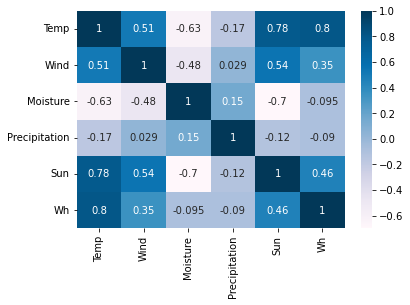

In [78]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap='PuBu')

In [79]:
train_x = train_x[['Temp','Sun']]
train_x

,Temp,Sun
0,17.6,0.0
1,17.7,0.0
2,17.5,0.0
3,17.1,0.0
4,17.0,0.0
...,...,...
83,23.9,0.6
84,25.0,0.8
85,26.0,1.0
86,26.4,1.0


정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : 상관계수가 0.4 이상인 Temp, Sun 

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [80]:
# 사용할 패키지를 import!
from sklearn.preprocessing import MinMaxScaler

In [81]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)
train_x

array([[0.20895522, 0.        ],
       [0.21641791, 0.        ],
       [0.20149254, 0.        ],
       [0.17164179, 0.        ],
       [0.1641791 , 0.        ],
       [0.15671642, 0.        ],
       [0.14179104, 0.        ],
       [0.15671642, 0.1       ],
       [0.2238806 , 0.3       ],
       [0.3358209 , 0.7       ],
       [0.42537313, 1.        ],
       [0.54477612, 1.        ],
       [0.61940299, 1.        ],
       [0.61940299, 1.        ],
       [0.65671642, 1.        ],
       [0.67164179, 1.        ],
       [0.71641791, 1.        ],
       [0.65671642, 1.        ],
       [0.58955224, 1.        ],
       [0.48507463, 1.        ],
       [0.37313433, 0.4       ],
       [0.28358209, 0.        ],
       [0.23134328, 0.        ],
       [0.17910448, 0.        ],
       [0.13432836, 0.        ],
       [0.10447761, 0.        ],
       [0.08208955, 0.        ],
       [0.06716418, 0.        ],
       [0.05223881, 0.        ],
       [0.        , 0.        ],
       [0.

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [82]:
# 사용할 패키지를 import!
from sklearn.linear_model import LinearRegression


In [83]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
model = LinearRegression().fit(train_x, train_y)

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [84]:
esti_y =  model.predict(train_x)
esti_y

array([8016.8103877 , 8023.95070749, 8009.67006791, 7981.10878877,
       7973.96846898, 7966.82814919, 7952.54750962, 7945.04961035,
       7965.75541076, 7985.74605221, 8006.09427315, 8120.33938974,
       8191.74258761, 8191.74258761, 8227.44418655, 8241.72482612,
       8284.56674484, 8227.44418655, 8163.18130846, 8063.21683144,
       8086.78326767, 8088.21358557, 8038.23134706, 7988.24910855,
       7945.40718983, 7916.84591068, 7895.42495132, 7881.14431175,
       7866.86367217, 7816.88143366, 7831.16207324, 7866.86367217,
       7902.56527111, 7966.82814919, 7995.38942834, 8009.67006791,
       7923.98623047, 8009.67006791, 8194.9608029 , 8252.44094068,
       8287.78496014, 8273.86190004, 8231.01998132, 8209.59902195,
       8181.03774281, 8159.61678344, 8138.19582408, 8116.77486472,
       8073.932946  , 8066.79262621, 8059.65230642, 8059.65230642,
       8052.51198664, 8052.51198664, 8016.8103877 , 8001.4570097 ,
       7970.75025369, 8158.18646554, 8287.42738066, 8344.19235

In [85]:
model.coef_

array([ 956.80285148, -217.78538838])

In [86]:
linear_beta = model.coef_
linear_intercept = model.intercept_
print(f"Beta(회귀 계수) :{linear_beta}")
print(f"Intercept(절편) : {linear_intercept}")

Beta(회귀 계수) :[ 956.80285148 -217.78538838]
Intercept(절편) : 7816.8814336615615


# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [87]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [88]:
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 11423.54088


In [89]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

In [90]:
# visualization 하실 분은 진행해주세요!
# visualize(model, train_x, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [92]:
# transform을 하시는 분들은 실행해주세요
test_x = scaler.transform(test_x[['Temp','Sun']])
test_x


array([[0.70895522, 0.        ],
       [0.62686567, 0.1       ],
       [0.59701493, 0.2       ],
       [0.51492537, 0.        ],
       [0.49253731, 0.        ],
       [0.44776119, 0.        ],
       [0.41044776, 0.        ],
       [0.38059701, 0.        ],
       [0.36567164, 0.        ],
       [0.35074627, 0.        ],
       [0.3358209 , 0.        ],
       [0.3358209 , 0.        ]])

In [95]:
# y1_hat에 predict값 할당
pred_y = model.predict(test_x)
pred_y

array([8495.21181344, 8394.88975694, 8344.54993896, 8309.56349897,
       8288.14253961, 8245.30062089, 8209.59902195, 8181.03774281,
       8166.75710323, 8152.47646366, 8138.19582408, 8138.19582408])

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [96]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [97]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 141209.94067


In [98]:
score(train_mse,test_mse)

 12.3613


In [25]:
# visualization 하실 분은 진행해주세요!
# visualize(model, test_x, test_y)

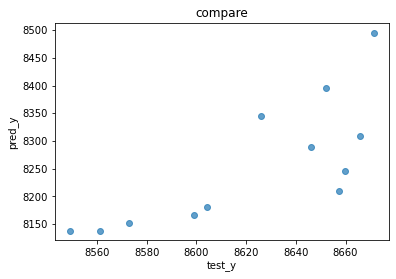

In [101]:
plt.scatter(test_y, pred_y, alpha=0.7)
plt.xlabel("test_y")
plt.ylabel("pred_y")
plt.title("compare")
plt.show()

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

고생하셨습니다!